In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import logging
import tensorflow as tf
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
import seaborn as sns

from ..environment.cart_pole import CartPoleEnv
from ..environment.cliff_walking import CliffWalkingEnv
from ..environment.frozen_lake import FrozenLakeEnv
from ..environment.mountain_car import MountainCarEnv

wrapper = CartPoleEnv()

ModuleNotFoundError: No module named 'environment'

In [3]:
import time

from ..agent import Agent, EpisodeStopConditionOrLimit, RunStopConditionOrLimit

def learn(
    agent: Agent,
    run_stop_condition: RunStopConditionOrLimit,
    episode_stop_condition: EpisodeStopConditionOrLimit,
    should_render: bool = False,
) -> None:
    start = time.time()
    total_reward, reward_history, episode_history = agent.fit(
        run_stop_condition, episode_stop_condition, should_render, True
    )
    end = time.time()

    agent._save_model()

    n = len(reward_history)

    print("epochs        : {}".format(n))
    print("total reward  : {:.3f}".format(total_reward))
    print("average reward: {:.3f}".format(total_reward / n))
    print("duration (s)  : {:.3f}".format(end - start))
    print()

    sns.relplot(x=[x for x in range(0, len(reward_history))], y=reward_history, kind="line")

In [4]:
import time

from ..agent import Agent, EpisodeStopConditionOrLimit, RunStopConditionOrLimit

def test(
    agent: Agent,
    run_stop_condition: RunStopConditionOrLimit,
    episode_stop_condition: EpisodeStopConditionOrLimit,
    should_render: bool = False,
) -> None:
    start = time.time()
    total_reward, reward_history, episode_history = agent.run(
        run_stop_condition, episode_stop_condition, should_render, False
    )
    end = time.time()

    n = len(reward_history)

    print("epochs        : {}".format(n))
    print("total reward  : {:.3f}".format(total_reward))
    print("average reward: {:.3f}".format(total_reward / n))
    print("duration (s)  : {:.3f}".format(end - start))
    print()

In [5]:
from ..agent import Agent
from ..environment import AgentConfig

def run_agent(
    agent: Agent,
    config: AgentConfig,
    render_learning=False,
    render_testing=True,
    continuous=False,
):
    learn(
        agent,
        config.train_stop_condition,
        config.episode_stop_condition,
        render_learning,
    )

    if not continuous:
        input()

    test(
        agent,
        config.test_stop_condition,
        config.episode_stop_condition,
        render_testing,
    )
    print()

In [6]:
from ..agent.q_learning.deep import DeepQLearningAgent

def run_q_agent_deep(
    render_learning=False, render_testing=True, continuous=False, cold_start=False
):
    print("=== Deep Q-Learning Agent ===")
    dql = DeepQLearningAgent(
        wrapper.env,
        wrapper.deep_q_agent.exploration_rate_min,
        wrapper.deep_q_agent.exploration_rate_max,
        wrapper.deep_q_agent.exploration_rate_decay,
        wrapper.deep_q_agent.decay_frequency,
        wrapper.learning_rate,
        wrapper.discount,
        wrapper.save_frequency,
        wrapper.deep_q_agent.update_target_frequency,
        wrapper.deep_q_agent.batch_size,
        wrapper.deep_q_agent.memory_limit,
        wrapper.model_builder,
        wrapper.model_predictor,
        wrapper.model_fitter,
        wrapper.model_copier,
        wrapper.model_loader,
        wrapper.model_saver,
        "__data__/dql/{}".format(wrapper.save_file),
        wrapper.process_percept,
        cold_start,
    )
    run_agent(dql, wrapper.deep_q_agent, render_learning, render_testing, continuous)

    return dql

In [7]:
from ..agent.nedrl.neat import NEATDRLAgent

def run_neat_drl_agent(
    render_learning=False, render_testing=True, continuous=False, cold_start=False
):
    print("=== NEAT DRL Agent ===")
    neat_drl = NEATDRLAgent(
        wrapper.env,
        wrapper.neat_drl_agent.exploration_rate_min,
        wrapper.neat_drl_agent.exploration_rate_max,
        wrapper.neat_drl_agent.exploration_rate_decay,
        wrapper.neat_drl_agent.decay_frequency,
        wrapper.learning_rate,
        wrapper.discount,
        wrapper.save_frequency,
        wrapper.neat_drl_agent.update_target_frequency,
        wrapper.neat_drl_agent.batch_size,
        wrapper.neat_drl_agent.memory_limit,
        wrapper.config_file,
        wrapper.neat_drl_agent.generations_per_update,
        "__data__/neat-drl/{}".format(wrapper.save_file),
        wrapper.process_percept,
        cold_start,
    )
    run_agent(
        neat_drl, wrapper.neat_drl_agent, render_learning, render_testing, continuous
    )

    return neat_drl

In [8]:
def print_config(file: str):
    with open(file, mode="r", encoding="utf-8") as f:
        while l := f.readline():
            print(l.strip())

print_config(wrapper.config_file)

# Configuration file for the CartPole-v1 environment

[GENERAL]
SaveFrequency = 1
SaveFile = cart_pole
LearningRate = 0.01
DiscountRate = 0.9

[RANDOM-AGENT]
EpsilonMin = 0.01
EpsilonMax = 1.0
EpsilonDecay = 0.99
DecayFrequency = 1000
MaxSteps = 1000
EpisodeCount = 1
TestCount = 1

[Q-AGENT-TABULAR]
EpsilonMin = 0.01
EpsilonMax = 1.0
EpsilonDecay = 0.99
DecayFrequency = 100
MaxSteps = 1000
EpisodeCount = 1
TestCount = 1
FloatSamples = 128
FloatMin = -32
FloatMax = 32

[NEAT-AGENT]
EpsilonMin = 0.01
EpsilonMax = 1.0
EpsilonDecay = 0.99
DecayFrequency = 100
MaxSteps = 1000
EpisodeCount = 1
TestCount = 1
GenerationsPerEpisode = 1

[Q-AGENT-DEEP]
EpsilonMin = 0.01
EpsilonMax = 1.0
EpsilonDecay = 0.99
DecayFrequency = 100
MaxSteps = 1000
EpisodeCount = 100
TestCount = 10
UpdateTargetFrequency = 100
BatchSize = 64
MemoryLimit = 4096
EpochsPerUpdate = 1

[NEAT-DRL-AGENT]
EpsilonMin = 0.01
EpsilonMax = 1.0
EpsilonDecay = 0.9
DecayFrequency = 100
MaxSteps = 1000
EpisodeCount = 200
TestCount = 1

In [9]:
from ..agent import Agent
from ..agent.nedrl.neat import NEATDRLAgent
from ..environment import AgentConfig
from ..environment.cart_pole import CartPoleEnv

cold_start = True
render_learning = False
render_testing = False
continuous = True

In [10]:
# run_random_agent(render_learning, render_testing, continuous, cold_start)

In [11]:
# run_neat_agent(render_learning, render_testing, continuous, cold_start)

=== Deep Q-Learning Agent ===


learning: 100ep [05:46,  3.46s/ep]


epochs        : 100
total reward  : 4909.938
average reward: 49.099
duration (s)  : 346.019



running: 10ep [01:15,  7.56s/ep]

epochs        : 10
total reward  : 4002.619
average reward: 400.262
duration (s)  : 75.589




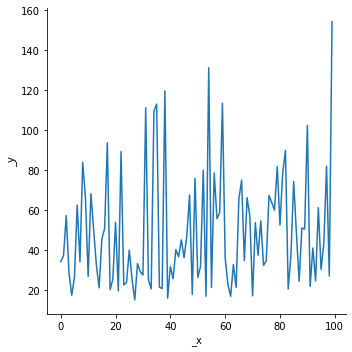

In [12]:
dql = run_q_agent_deep(render_learning, render_testing, continuous, cold_start)

=== NEAT DRL Agent ===


learning: 200ep [36:47, 11.04s/ep]


epochs        : 200
total reward  : 4139.502
average reward: 20.698
duration (s)  : 2207.398



running: 100ep [00:01, 55.60ep/s]


epochs        : 100
total reward  : 1595.931
average reward: 15.959
duration (s)  : 1.801




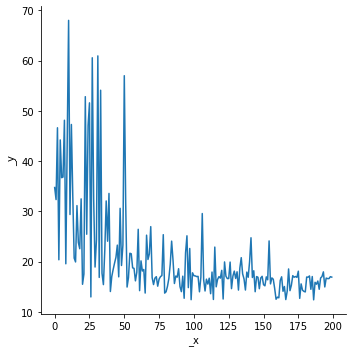

In [13]:
nedrl = run_neat_drl_agent(render_learning, render_testing, continuous, cold_start)

<AxesSubplot:>

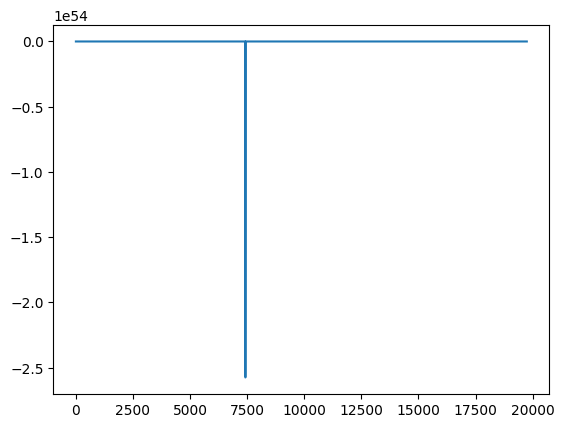

In [14]:
sns.lineplot(x=[x for x in range(0, len(nedrl.fitness_history))], y=nedrl.fitness_history)

<AxesSubplot:>

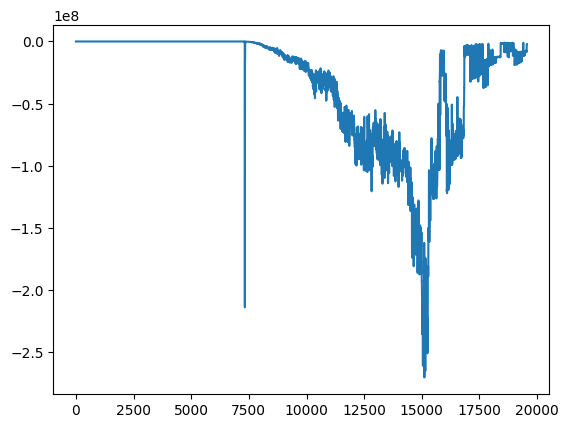

In [15]:
import numpy as np

def remove_outliers(arr: np.ndarray, percentile=0.001):
    low, high = np.quantile(arr, [percentile * 0.5, 1 - percentile * 0.5])
    return arr[(arr >= low)&(arr <= high)]

removed_outliers = remove_outliers(np.array(nedrl.fitness_history), 0.01)

sns.lineplot(x=[x for x in range(0, len(removed_outliers))], y=removed_outliers)